In [2]:
!pip install deepxde

Defaulting to user installation because normal site-packages is not writeable


Deepxde only uses real numbers, so I  need to explicitly split the real and imaginary parts of the complex PDE.


In [3]:
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [4]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [5]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [6]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [7]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

In [8]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.145841 s



C:\Users\zulkarnain prastyo\AppData\Roaming\Python\Python310\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.604132 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.50e-02, 2.34e-02, 1.43e-01, 2.38e-03, 6.94e-01, 6.87e-05, 1.01e+00, 8.41e-02]    [3.50e-02, 2.34e-02, 1.43e-01, 2.38e-03, 6.94e-01, 6.87e-05, 1.01e+00, 8.41e-02]    []  
1000      [1.28e-02, 1.55e-02, 9.51e-06, 2.06e-04, 5.20e-06, 2.35e-06, 2.02e-02, 2.24e-03]    [1.28e-02, 1.55e-02, 9.51e-06, 2.06e-04, 5.20e-06, 2.35e-06, 2.02e-02, 2.24e-03]    []  
2000      [8.32e-03, 9.71e-03, 3.26e-05, 8.55e-05, 2.41e-05, 2.48e-05, 1.21e-02, 5.58e-04]    [8.32e-03, 9.71e-03, 3.26e-05, 8.55e-05, 2.41e-05, 2.48e-05, 1.21e-02, 5.58e-04]    []  
3000      [5.32e-03, 5.48e-03, 2.75e-06, 3.40e-05, 2.23e-05, 4.17e-05, 6.16e-03, 4.88e-05]    [5.32e-03, 5.48e-03, 2.75e-06, 3.40e-05, 2.23e-05, 4.17e-05, 6.16e-03, 4.88e-05]    []  
4000  

(<deepxde.model.LossHistory at 0x1e672cd4eb0>,
 <deepxde.model.TrainState at 0x1e672cd5210>)

In [9]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 1.076994 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [1.80e-03, 2.65e-03, 1.13e-04, 2.97e-06, 5.37e-07, 2.23e-06, 1.26e-04, 1.67e-05]    [1.80e-03, 2.65e-03, 1.13e-04, 2.97e-06, 5.37e-07, 2.23e-06, 1.26e-04, 1.67e-05]    []  
11000     [1.96e-05, 2.97e-05, 7.53e-08, 8.04e-07, 6.90e-08, 3.09e-07, 8.82e-06, 7.32e-07]    [1.96e-05, 2.97e-05, 7.53e-08, 8.04e-07, 6.90e-08, 3.09e-07, 8.82e-06, 7.32e-07]        
12000     [5.93e-06, 8.79e-06, 1.99e-08, 1.28e-07, 3.06e-08, 2.23e-07, 5.01e-06, 1.51e-07]    [5.93e-06, 8.79e-06, 1.99e-08, 1.28e-07, 3.06e-08, 2.23e-07, 5.01e-06, 1.51e-07]        
13000     [3.04e-06, 3.77e-06, 8.41e-09, 1.57e-07, 1.30e-08, 1.22e-07, 3.76e-06, 7.08e-08]    [3.04e-06, 3.77e-06, 8.41e-09, 1.57e-07, 1.30e-08, 1.22e-07, 3.76e-06, 7.08e-08]        
14000     [1.

(<deepxde.model.LossHistory at 0x1e672cd4eb0>,
 <deepxde.model.TrainState at 0x1e672cd5210>)

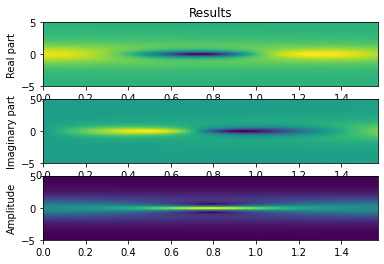

In [10]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()